In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import brentq,minimize
import seaborn as sns
import os
import imageio

# Data

In [2]:
data_dir = '/Users/vamsi/Desktop/phd/mcml/projects/pw_lof/ti64_data/master_data/CMU_ULI_DATA/'
st_data = pd.read_csv(data_dir+'stwidths.csv')
mt_data = pd.read_csv(data_dir+'MTMeasurements.csv')
vels = np.unique(st_data['Velocity (mm/s)'])
angles = np.unique(st_data['Orientation (degrees)'])

In [3]:
st_whash = {} 
for vel in vels:
    for angle in angles:
        va = '{}_{}'.format(vel,angle)
        st_whash[va] = st_data[(st_data['Velocity (mm/s)']==vel) & (st_data['Orientation (degrees)']==angle)]['Width (um)'].to_numpy()

In [4]:
locs = st_data[(st_data['Velocity (mm/s)']==1700) & (st_data['Orientation (degrees)']==0)]['Location (um)'].to_numpy()
dist_traveled_mm = (locs[-1]-locs[0])/1e3
time_traveled = dist_traveled_mm/1700

In [5]:
tspace_1700 = np.linspace(0,time_traveled,len(st_whash['1700_0']))

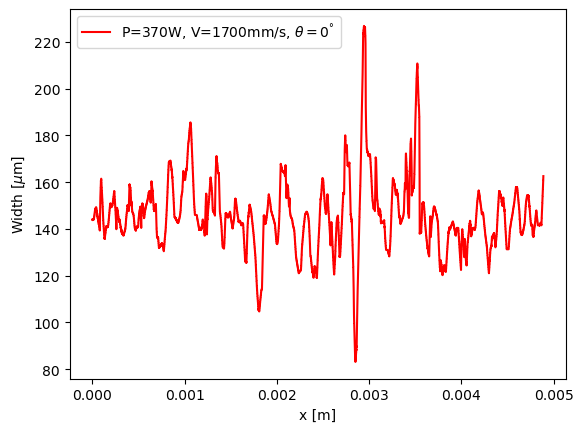

In [6]:
plt.plot(tspace_1700,st_whash['1700_0'],color='r',label=r'P=370W, V=1700mm/s, $\theta=0^\degree$')
plt.xlabel(r'x [m]')
plt.ylabel(r'Width [$\mu$m]')
plt.legend()
plt.savefig('exp_data.pdf',bbox_inches='tight')

# Rosenthal model for temperature field

In [7]:
class RosenthalField:
    def __init__(self,laser_params,material_params,sig_mf=5):
        
        self.p = laser_params['p']
        self.v = laser_params['v']
        self.cond = material_params['k']
        self.abs = material_params['alpha']
        self.dens = material_params['rho']
        self.specheat = material_params['cp']
        self.t0 = material_params['t0']
        self.tl = material_params['tl']

        self.state = [self.cond,self.abs,self.dens,self.specheat]
        self.sig_mf=5

    def update_state(self,newstate):
        self.state = newstate
        self.cond,self.abs,self.dens,self.specheat = newstate
    def disp_state(self):
        print('conductivity: {0:.2f}\nabsorptivity: {1:.3f}\ndensity: {2:.2f}\nspecific heat: {3:.2f}'.format(self.state[0],
                                                                                                              self.state[1],
                                                                                                              self.state[2],
                                                                                                              self.state[3]))
    def evaluate_temp(self,x,y,t,state):
        # returns temperature of point x,y at time t
        local_ref = np.array([self.v*t,0])
        local_ref_coords = np.array([x,y])-local_ref
        k,alpha,rho,cp = state
        r = np.linalg.norm(local_ref_coords)
        return self.t0 + alpha*self.p/(2*np.pi*r*k)*np.exp(-self.v*(np.abs(local_ref_coords[0]+r))/(2*k/(rho*cp)))
        

    def estimate_width(self,method='brents',sig_mf=5):
        if method=='brents':
            # brents method from Josh's paper
            M = self.v*self.dens*self.specheat/(2*self.cond)
            N = 2*np.pi*self.cond*(self.tl-self.t0)/(self.abs*self.p)

            def rw_polynomial(Rw):
                return pow(M,2)*pow(Rw,2)/(M*Rw+1) - M*Rw - np.log(M*Rw) + np.log(M/N)

            Rw_space = np.linspace(25e-6,1e-3,100)
            Rw_bounds = [Rw_space[0],Rw_space[-1]]
            Rw = brentq(rw_polynomial,Rw_bounds[0],Rw_bounds[1])

            phiw = np.arccos(-M*Rw/(M*Rw+1))
            if sig_mf!=0:
                return 2*Rw*np.sin(phiw)*1e6 + np.random.normal(scale=self.sig_mf)
            else:
                return 2*Rw*np.sin(phiw)*1e6
            
        elif method=='tang':
            # tang approximation
            t1 = 0.125*np.e*np.pi*self.dens*self.specheat*(self.tl-self.t0)*self.v
            t2 = np.pi*self.cond*(self.tl-self.t0)
            t3 = -self.abs*self.p
            ws = np.roots([t1,t2,t3])
            return ws[np.where(ws>0)]


    def init_exp_data(self,T,data,subsample = 50):
        idx = np.arange(0,len(data),1/subsample * len(data),dtype='int')
        self.timedomain = T[idx]
        self.expdata = data[idx]

    def ols_min(self,bounds,verbose = True):
        self.bounds = bounds
    # defining the cost function as the ls error 
        try:
            temp = self.timedomain[0]
        except:
            print('Must define experimental data to continue.')
            return None
        def obj(theta):
            k,alpha,rho,cp = theta
            self.cond = k
            self.abs = alpha
            self.dens = rho
            self.specheat = cp
            
            return np.abs(self.expdata[0]-self.estimate_width(sig_mf=0))

        res = minimize(obj,[self.cond,self.abs,self.dens,self.specheat],
                       bounds = bounds,
                       method='Nelder-Mead')

        newstate = res.x
        self.update_state(newstate)
        self.ols_init = newstate
        if verbose:
            print('Minimized LS error w.r.t. first value in experimental data.')
            print('New values are the following:')
            self.disp_state()

    def test_particle_bounds(self,particle):
        try:
            temp = self.bounds[0]
        except:
            print('Must assign bounds for each parameter before continuing.')
            return None

        for pi,bound in zip(particle,self.bounds):
            if bound[0]>pi or bound[1]<pi:
                return False
        return True

    def eval_likelihood(self,particle,wt,sig_mf=5):
        # evaluates particle likelihood based on euclidean distance between prediction and true value
        self.update_state(particle)
        pwt = self.estimate_width()
        delta = np.abs(pwt-wt)
        return pow(sig_mf*pow(2*np.pi,0.5),-1)*np.exp(-0.5*pow(delta/sig_mf,2))
        
    def run_particle_filter(self,bounds,M,olsguess=True,init_around_ols=0.5):
        
        ### INITIAL GUESS ###
        # If olsguess is true, then the best ols estimator for the parameter will be solved for
        # and the init_around_ols*M particles will be initialized around that guess
        self.bounds = bounds
        self.M = M
        if olsguess:
            self.ols_min(self.bounds,verbose=False)


        ### PARTICLE INITIALIZATION ###
        # initialize particles with uniform distribution defined by bounds input
        # the fraction of particles initialized around the ols guess is given by init_around_ols
        # the particles initialized around the ols guess are normally distributed with sig = 0.1 *(b-a) from bounds
        self.particles = []
        self.weights = np.ones(M)/M # uniform weights
        k_ols = int(np.around(M*init_around_ols))
        bounds_sigs = np.array([np.diff(bound) for bound in self.bounds])/2
        for i in range(k_ols):
            cond_k = np.random.normal(loc=self.cond,scale=bounds_sigs[0])
            abs_k = np.random.normal(loc=self.abs,scale=bounds_sigs[1])
            dens_k = np.random.normal(loc=self.dens,scale=bounds_sigs[2])
            specheat_k = np.random.normal(loc=self.specheat,scale=bounds_sigs[3])
            particle = np.vstack([cond_k,abs_k,dens_k,specheat_k])

            while not self.test_particle_bounds(particle):
                cond_k = np.random.normal(loc=self.cond,scale=bounds_sigs[0])
                abs_k = np.random.normal(loc=self.abs,scale=bounds_sigs[1])
                dens_k = np.random.normal(loc=self.dens,scale=bounds_sigs[2])
                specheat_k = np.random.normal(loc=self.specheat,scale=bounds_sigs[3])
                particle = np.vstack([cond_k,abs_k,dens_k,specheat_k])
            
            self.particles.append(particle.flatten())

        for i in range(M-k_ols):
            cond_k = np.random.uniform(low=self.bounds[0][0],high=self.bounds[0][1])
            abs_k = np.random.uniform(low=self.bounds[1][0],high=self.bounds[1][1])
            dens_k = np.random.uniform(low=self.bounds[2][0],high=self.bounds[2][1])
            specheat_k = np.random.uniform(low=self.bounds[3][0],high=self.bounds[3][1])
            particle = np.array([cond_k,abs_k,dens_k,specheat_k])
            self.particles.append(particle)
        
        self.particles = np.array(self.particles)
        self.particle_history = [self.particles]
        self.weight_history = [self.weights]

        ### PARTICLE FILTER ALGORITHM ###

        for t in range(len(self.expdata)):
            # new datapoint
            wt = self.expdata[t]
            new_weights = []
            for k in range(M):
                # test likelihoods of particles
                particlek = self.particles[k]
                Lk = self.eval_likelihood(particlek,wt,sig_mf=self.sig_mf)
                wk = self.weights[k]
                # reweight particles
                if np.isnan(pow(-np.log(Lk*wk),-1)):
                    new_weights.append(0)
                    print('low likelihood encountered')
                else:
                    new_weights.append(pow(-np.log(Lk*wk),-1))

            new_weights = np.array(new_weights)/np.sum(new_weights)
            self.weight_history.append(new_weights)
            
            # weight filter: keep only the top 75% by likelihood. reinitialize the other particles
            weight_filter = np.quantile(new_weights,0.25)
            weights_kept = np.where(new_weights>weight_filter)

            filtered_weights = new_weights[weights_kept]/np.sum(new_weights[weights_kept])
            particles_kept = self.particles[weights_kept]

            cumsum_sampler = np.hstack([0,np.cumsum(filtered_weights)])

            new_particles = []
            for i in range(len(weights_kept)):
                # resample the high likelihood particles
                u = np.random.uniform()
                idx = np.where(u>cumsum_sampler)[0][-1]
                new_particles.append(self.particles[idx])

            for i in range(self.M - len(weights_kept)):
                # initialize new particles to ensure diversity
                cond_k = np.random.uniform(low=self.bounds[0][0],high=self.bounds[0][1])
                abs_k = np.random.uniform(low=self.bounds[1][0],high=self.bounds[1][1])
                dens_k = np.random.uniform(low=self.bounds[2][0],high=self.bounds[2][1])
                specheat_k = np.random.uniform(low=self.bounds[3][0],high=self.bounds[3][1])
                particle = np.array([cond_k,abs_k,dens_k,specheat_k])
                new_particles.append(particle)

            self.particles = np.array(new_particles)
            self.particle_history.append(self.particles)

            print('Finished timestep {}/{}'.format(t+1,len(self.expdata)),end='\r')

    def evaluate_filter(self,mode='likelihood',epistemic_runs=20,store_optimal=True):
        # evaluates the particle filter results based on the mode of evaluation
        optimal_particles = []
        if mode=='likelihood':
            # pick the particle in each history timestep with the maximum likelihood
            # evaluate the width model at that particle
            model_results = []
            for t in range(len(self.particle_history)-1):
                model_evals = []
                wt = self.expdata[t]
                L_arr = [self.eval_likelihood(particle,wt) for particle in self.particle_history[t]]
                optimal_particle = self.particle_history[t][np.argmax(L_arr)]
                optimal_particles.append(optimal_particle)
                self.update_state(optimal_particle)
                for n in range(epistemic_runs):
                    pred_w = self.estimate_width()
                    model_evals.append(pred_w)
                model_results.append(model_evals)
            if store_optimal:
                self.optimal_particles = np.array(optimal_particles)
            return np.array(model_results)

        elif mode=='stat':
            pass

# Particle filter

In [8]:
laser = {'p':370,'v':1.7}
ti64 = {'k':25,
        'alpha':0.5,
        'rho':4400,
        'cp':1000,
        't0':298,
        'tl':1660}
bounds = [[20,30],[0.3,0.8],[4200,4600],[600,1100]]

In [9]:
import time
start_time = time.perf_counter()
rosenthal_field_ti64 = RosenthalField(laser,ti64)
rosenthal_field_ti64.init_exp_data(tspace_1700,st_whash['1700_0'],subsample=500)
rosenthal_field_ti64.run_particle_filter(bounds,500,init_around_ols=0.5)
end_time = time.perf_counter()
elapsed_time = end_time - start_time

Finished timestep 500/500

In [10]:
print(elapsed_time)

11.616698291967623


In [11]:
start_time = time.perf_counter()
model_results = rosenthal_field_ti64.evaluate_filter()
model_mean = np.array([np.mean(mt) for mt in model_results])
model_sd = np.array([np.std(mt) for mt in model_results])
end_time = time.perf_counter()
print(end_time-start_time)

9.481762207986321


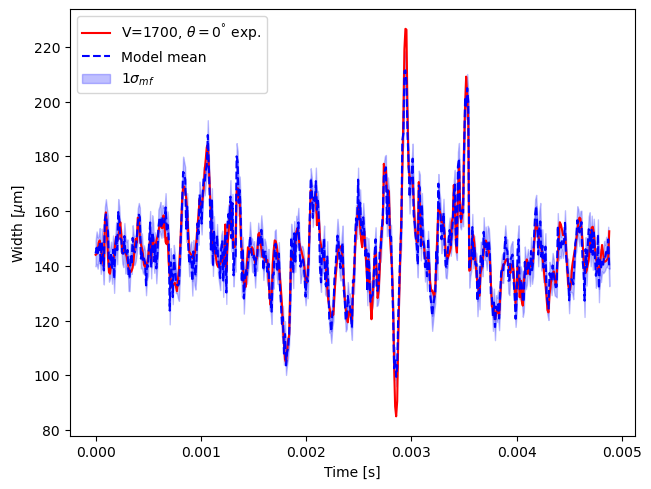

In [12]:
#plt.plot(tspace_1700[:5000],st_whash['1700_0'][:5000])
plt.plot(rosenthal_field_ti64.timedomain,rosenthal_field_ti64.expdata,c='r',label=r'V=1700, $\theta=0^\degree$ exp.')
plt.plot(rosenthal_field_ti64.timedomain,model_mean,c='b',ls='--',label='Model mean')
plt.fill_between(rosenthal_field_ti64.timedomain,model_mean,model_mean+model_sd,alpha=0.25,color='b',label=r'1$\sigma_{mf}$')
plt.fill_between(rosenthal_field_ti64.timedomain,model_mean,model_mean-model_sd,alpha=0.25,color='b')
plt.legend(loc='upper left')
plt.tight_layout()
plt.xlabel('Time [s]')
plt.ylabel(r'Width [$\mu$m]')
plt.savefig('calibrated_filter.pdf',bbox_inches='tight')

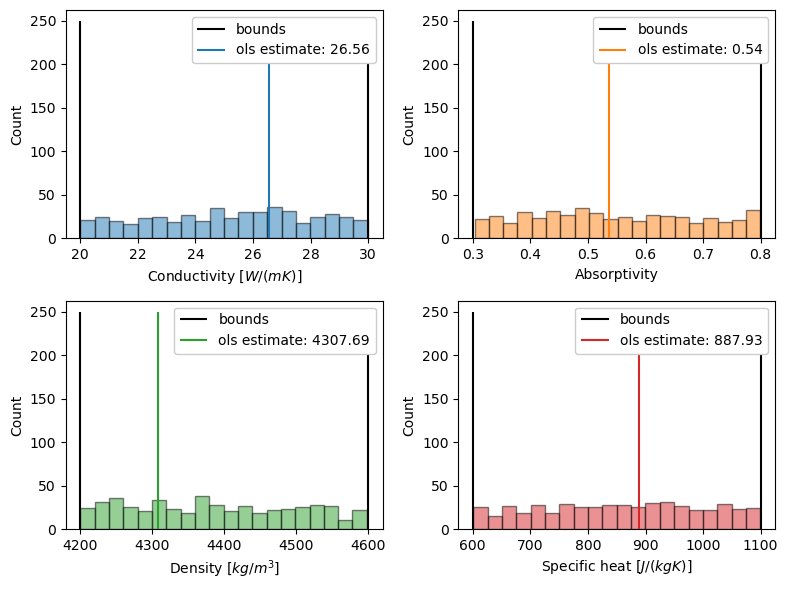

In [13]:
fig,ax = plt.subplots(2,2,figsize=(8,6))
init_particles = rosenthal_field_ti64.particle_history[0]
for i in range(len(rosenthal_field_ti64.ols_init)):
    ax[i//2,i%2].hist(init_particles[:,i],edgecolor='k',color='C{}'.format(i),alpha=0.5,bins=20)
    ax[i//2,i%2].vlines(rosenthal_field_ti64.bounds[i],0,rosenthal_field_ti64.M/2,color='k',label='bounds')
    ax[i//2,i%2].vlines(rosenthal_field_ti64.ols_init[i],0,rosenthal_field_ti64.M/2,color='C{}'.format(i),label='ols estimate: {:.2f}'.format(rosenthal_field_ti64.ols_init[i]))
    ax[i//2,i%2].legend(framealpha=1)
ax[0,0].set_xlabel('Conductivity $[W/(mK)]$')
ax[0,1].set_xlabel('Absorptivity')
ax[1,0].set_xlabel('Density $[kg/m^3]$')
ax[1,1].set_xlabel('Specific heat $[J/(kgK)]$')
for i in range(len(rosenthal_field_ti64.ols_init)):
    ax[i//2,i%2].set_ylabel('Count')
plt.tight_layout()
fig.savefig('OLS_init.pdf',bbox_inches='tight')

In [14]:
for i in range(len(rosenthal_field_ti64.particle_history)-1):
    fig,ax = plt.subplots(figsize=(8,6))
    sns.kdeplot(rosenthal_field_ti64.particle_history[i][:,3],c='C3',ax=ax,label=r'Specific heat kde, t={:.2f} $\mu$s'.format(rosenthal_field_ti64.timedomain[i]*1e6))
    plt.vlines(rosenthal_field_ti64.optimal_particles[i][3],0,0.0028,ls='--',color='C3',
               label=r'Optimal particle, $C_p$={:.2f}'.format(rosenthal_field_ti64.optimal_particles[i][3]))
    ax.set_xlim(500,1200)
    ax.set_ylim(0,0.003)
    ax.set_xlabel('Specific heat [$J/(kgK)$]')
    ax.legend(loc='upper left')
    #fig.savefig('lambda_t{}.png'.format(i),bbox_inches='tight')
    plt.close(fig)
    #print('saved {} of {}'.format(i,len(rosenthal_field_ti64.particle_history)-1),end='\r')

In [105]:
def make_gif(fn,n,targ,dur=125):
    images = []
    for i in range(n):
        image = imageio.imread(fn+'_t{}.png'.format(i))
        images.append(image)
    
    imageio.mimsave(targ+'.gif', images,duration=dur)

# Field visualization

In [15]:
class RosenthalVisualizer:
    def __init__(self,laser_params,material_params):
        self.p = laser_params['p']
        self.v = laser_params['v']
        self.cond = material_params['k']
        self.abs = material_params['alpha']
        self.dens = material_params['rho']
        self.specheat = material_params['cp']
        self.t0 = material_params['t0']
        self.tl = material_params['tl']

        

    def init_domain(self):
        xtraveled = self.v*rosenthal_field_ti64.timedomain[-1]
        print(xtraveled)
        self.x = np.linspace(0-xtraveled/8,xtraveled+xtraveled/8,len(rosenthal_field_ti64.timedomain)*5)
        self.y = np.arange(-rosenthal_field_ti64.expdata.mean()*2*1e-6,rosenthal_field_ti64.expdata.mean()*2*1e-6,np.diff(self.x)[-1])
        self.mgridx,self.mgridy = np.meshgrid(self.x,self.y)
        
    def eval_params(self,t,state):
        temps = []
        for xx,yy in zip(self.mgridx,self.mgridy):
            temp_eval = [rosenthal_field_ti64.evaluate_temp(x,y,t,state) for x,y in zip(xx,yy)]
            temp_filter = [temp if temp <= 3133 else 3133 for temp in temp_eval]
            temps.append(temp_filter)
        return np.array(temps)

    def generate_gif(self,static=True):
        ## if static is true, then the parameters are constant
        if static:
            for i,t in enumerate(rosenthal_field_ti64.timedomain[len(rosenthal_field_ti64.timedomain)//2:len(rosenthal_field_ti64.timedomain)//2+2]):
                temps = self.eval_params(t,rosenthal_field_ti64.ols_init)
                fig,ax = plt.subplots(figsize=(10,6))
                ros = ax.contourf(rosenthal_vis.mgridx,rosenthal_vis.mgridy,temps,
                levels=np.linspace(298,3113,10),cmap='jet')
                ax.contour(rosenthal_vis.mgridx,rosenthal_vis.mgridy,temps,
                levels=[1616],cmap='Reds_r')
                ax.scatter(rosenthal_vis.v*t,0,facecolor='w',edgecolor='r',label='Laser position')
                fig.colorbar(ros,label='T (K)')
                ax.set_xlabel('x (m)')
                ax.set_ylabel('y (m)')
                plt.tight_layout()
                fig.savefig('rosenthal_static_t{}'.format(i))
                plt.close(fig)
                print('Saved timestep {} of {}'.format(i,len(rosenthal_field_ti64.timedomain)),end='\r')
        else:
            for i,t in enumerate(rosenthal_field_ti64.timedomain[:2]):
                state = rosenthal_field_ti64.optimal_particles[i]
                temps = rosenthal_vis.eval_params(t,state)
                fig,ax = plt.subplots(figsize=(10,6))
                ros=ax.contour(rosenthal_vis.mgridx,rosenthal_vis.mgridy,temps,levels=[1616],cmap='jet')
                ax.scatter(rosenthal_vis.v*t,0,facecolor='w',edgecolor='r',label='Laser position')
                #fig.colorbar(ros,label='T (K)')
                ax.set_xlabel('x (m)')
                ax.set_ylabel('y (m)')
                plt.tight_layout()
                fig.savefig('rosenthal_optimalparticle_t{}.png'.format(i))
                plt.close(fig)
                print('Saved timestep {} of {}'.format(i,len(rosenthal_field_ti64.timedomain)),end='\r')

In [16]:
rosenthal_vis = RosenthalVisualizer(laser,ti64)

In [17]:
rosenthal_vis.init_domain()

0.00829338


In [56]:
rosenthal_vis.generate_gif()

Saved timestep 1 of 500

# Visualization of width response with underlying variable response

In [18]:
for i in range(len(rosenthal_field_ti64.expdata)):
    fig,ax = plt.subplots(figsize=(10,6))
    ax.plot(rosenthal_field_ti64.timedomain[:i],model_results.mean(axis=1)[:i],c='b')
    ax.plot(rosenthal_field_ti64.timedomain[:i],rosenthal_field_ti64.expdata[:i],c='r')
    ax.scatter(rosenthal_field_ti64.timedomain[i-1],model_results.mean(axis=1)[i-1],marker='s',edgecolor='b',facecolor='w',
               label='Mean evaluation, best particle')
    ax.scatter(rosenthal_field_ti64.timedomain[i-1],rosenthal_field_ti64.expdata[i-1],marker='s',edgecolor='r',facecolor='w',
               label='Experiment, V=1700mm/s')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel(r'Width [$\mu$m]')
    ax.set_xlim(0,rosenthal_field_ti64.timedomain[-1])
    ax.set_ylim(80,230)
    ax.legend(loc='upper left')
    #fig.savefig('mean_eval_t{}.png'.format(i))
    plt.close(fig)
    #print('Plotted figure {} of {}'.format(i,len(rosenthal_field_ti64.expdata)),end='\r')

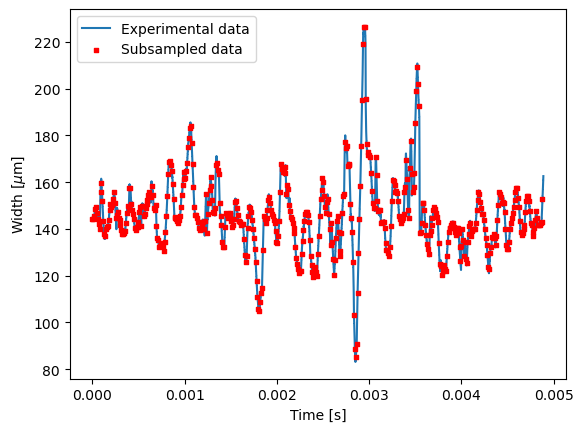

In [62]:
plt.plot(tspace_1700,st_whash['1700_0'],label='Experimental data')
plt.scatter(rosenthal_field_ti64.timedomain,rosenthal_field_ti64.expdata,marker='s',c='r',zorder=2,s=5,
            label='Subsampled data')
plt.xlabel('Time [s]')
plt.ylabel(r'Width [$\mu$m]')
plt.legend(loc='upper left')
plt.savefig('subsampled_data.pdf',bbox_inches='tight')

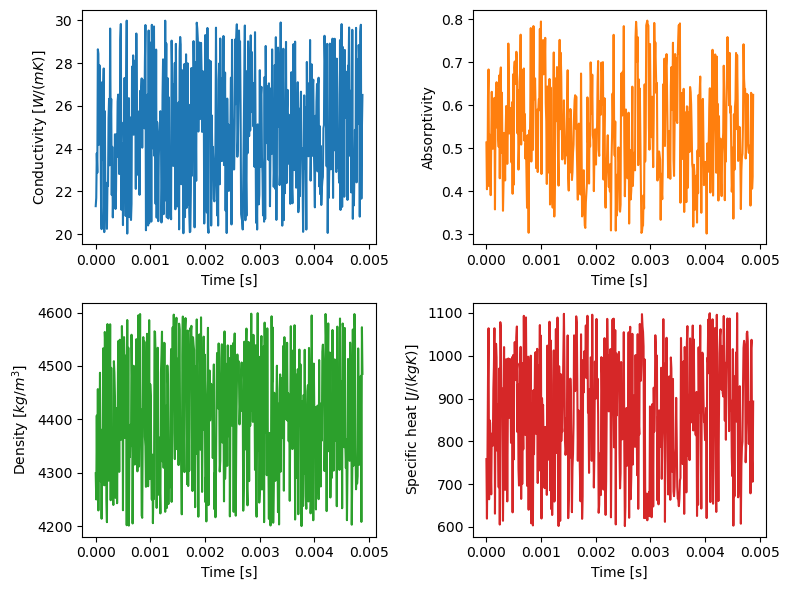

In [63]:
fig,ax = plt.subplots(2,2,figsize=(8,6))
init_particles = rosenthal_field_ti64.particle_history[0]
for i in range(len(rosenthal_field_ti64.ols_init)):
    ax[i//2,i%2].plot(rosenthal_field_ti64.timedomain,rosenthal_field_ti64.optimal_particles[:,i],c='C{}'.format(i))
ax[0,0].set_ylabel('Conductivity $[W/(mK)]$')
ax[0,1].set_ylabel('Absorptivity')
ax[1,0].set_ylabel('Density $[kg/m^3]$')
ax[1,1].set_ylabel('Specific heat $[J/(kgK)]$')
for i in range(len(rosenthal_field_ti64.ols_init)):
    ax[i//2,i%2].set_xlabel('Time [s]')
plt.tight_layout()
fig.savefig('optimal_particles.pdf',bbox_inches='tight')

In [91]:
max_tempdiff = []
min_tempdiff = []
temp_diffs = []
for t in range(len(rosenthal_field_ti64.timedomain)):
    temps_stochastic = rosenthal_vis.eval_params(rosenthal_field_ti64.timedomain[t],rosenthal_field_ti64.optimal_particles[t])
    temps_deterministic = rosenthal_vis.eval_params(rosenthal_field_ti64.timedomain[t],rosenthal_field_ti64.ols_init)
    temp_diff = temps_deterministic-temps_stochastic
    temp_diffs.append(temp_diff)
    max_tempdiff.append(temp_diff.max())
    min_tempdiff.append(temp_diff.min())
    print('finished timestep {} of {}'.format(t,len(rosenthal_field_ti64.timedomain)),end='\r')

finished timestep 499 of 500

In [99]:
mindiff = np.min(min_tempdiff)
maxdiff = np.max(max_tempdiff)

In [103]:
for i in range(len(rosenthal_field_ti64.timedomain)):
    fig,ax = plt.subplots(figsize=(10,6))
    diff_contours = ax.contourf(rosenthal_vis.mgridx,rosenthal_vis.mgridy,temp_diffs[i],cmap='coolwarm',levels=np.linspace(mindiff,maxdiff,20))
    fig.colorbar(diff_contours,label='T (K)')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    plt.tight_layout()
    plt.savefig('tfield_diff_t{}.png'.format(i),bbox_inches='tight')
    plt.close(fig)
    print('saved figure {} of {}'.format(i,500),end='\r')

saved figure 499 of 500

In [107]:
make_gif('tfield_diff',500,'tempfield_diff')

/var/folders/pv/0gl9d_6j40n2514jv16kkjwr0000gn/T/ipykernel_75967/2058352395.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(fn+'_t{}.png'.format(i))
